In [1]:
import numpy as np
import matplotlib.pyplot as plt

We're going to go step by step and implement gradient descent from scratch to fit a linear function to some data.  
First, let's create some data that follows a linear trend:

In [2]:
seed = np.random.seed(seed = 12)
xs = np.arange(60)
noise = np.random.uniform(-35,35, size=(60,))

slope = 2.7 # target variable 1
intercept = .8 # target variable 2
ys = (slope * xs) + intercept + noise

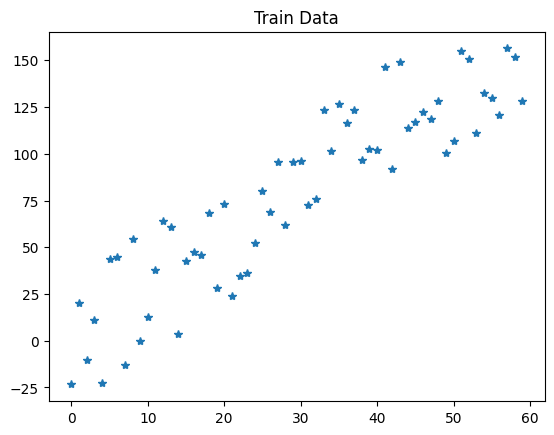

In [3]:
plt.figure()
plt.plot(xs, ys, '*')
plt.title('Train Data')
plt.show()

Now we'll create the function we want to approximate

In [4]:
def linear_model(x:np.ndarray, w:float, b:float) -> np.ndarray:
    """
    Takes input data and scales/shifts by weight and bias parameters.
    """
    return w * x + b

def loss(preds:np.ndarray, true:np.ndarray) -> float:
    """
    Calculates the MSE loss function
    """
    return np.mean((preds - true)**2)

In [5]:
b_rand = 0.1 # random initial guess
w_rand = 0.1 # random initial guess
model = linear_model(x = xs, w = w_rand, b = b_rand )

Now lets calculate the initial model error and do some parameter updates by hand:

In [6]:
err = loss(preds = model, true = ys)
print(f'error is: {err}')

error is: 7927.768803043679


Now what we want to try and do is estimate w and b such that the loss reaches some sort of minimum. We can do this with the gradient descent algorithm. First, as an example, we calculate the rate of change with respect to parameter w using the finite difference method:  
  
$$f'(x)=\lim_{h\to 0} \,\frac{f(x+h) - f(x)}{h}$$

In [7]:
# first see how the process works with a small step size
delta = 0.1

loss_change_w = (loss(preds=linear_model(x=xs, w=w_rand+delta, b=b_rand),true=ys) -
               loss(preds=model, true=ys)) / delta
print(f'Derivative of loss w.r.t param w is: {loss_change_w}')

Derivative of loss w.r.t param w is: -5800.311330034874


The way gradient descent works is by stepping our way in the direction of negative slope in Loss with respect to the model weights. We can do this via updates to the weights:  
$$w = w - λ * \frac{dLoss}{dw} $$  
  
Where $λ$ is a parameter called the learning rate which controls the gradient descent steps.

In [8]:
def w_updates(w:float, lr:float, dlw:np.ndarray) -> float:
  return w - (lr * dlw)

w_new = w_updates(w=w_rand, lr=0.001, dlw=loss_change_w)

In [9]:
print(f'New w weights are: {w_new}')

New w weights are: 5.9003113300348735


Now we can do the same with the b parameter

In [10]:
loss_change_b = (loss(preds=linear_model(x=xs, w=w_rand, b=b_rand+delta),true=ys) -
               loss(preds=model, true=ys)) / delta
print(f'Derivative of loss w.r.t params b is: {loss_change_b}')

Derivative of loss w.r.t params b is: -150.70442020019982


In [11]:
def b_updates(b:np.ndarray, lr:float, dlw:np.ndarray) -> float:
  return b - (lr * dlw)

b_new = b_updates(b=b_rand, lr=0.001, dlw=loss_change_b)
print(f'new b value: {b_new}')

new b value: 0.25070442020019984


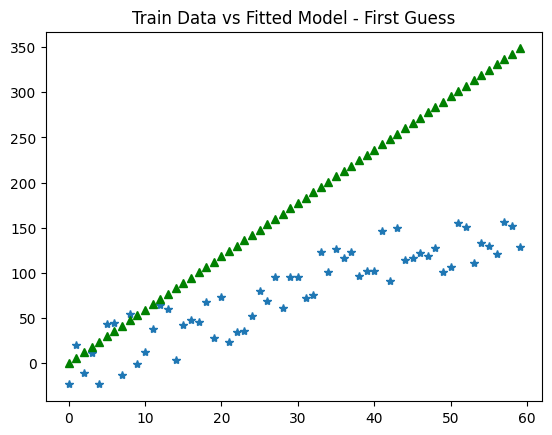

In [12]:
plt.figure()
plt.plot(xs, ys, '*')
plt.plot(xs, linear_model(x=xs, w=w_new, b=b_new), 'g^')
plt.title('Train Data vs Fitted Model - First Guess')
plt.show()

What we want to do now is properly compute the individual derivatives of the loss with respect to each parameter, and then use those to update the parameters.

We can do this with the chain rule, where we compute the derivative of the loss with respect to the input (which is the model output y=mx+b), and multiply this by the derivative of the model with respect to the parameter. We can show this by calculating the derivative of the loss with respect to the weight paramter:
  
$$\frac{dL}{dw} = (\frac{dL}{dy}) * (\frac{dy}{dw}) $$


Let's calculate the derivatives to work out the final expression:  
  
$$ \frac{dL}{dw} = \frac{-2}{n}\Sigma (x_i) (y_i - (wx_i + b)) $$

$$ \frac{dL}{db} = \frac{-2}{n} \Sigma (y_i - (wx_i +b)) $$

Where n is the length of the input data.

In [13]:
# define the functions we'll use in calculating gradient descent

def dldw(x:np.ndarray, diff:np.ndarray) -> float:
  """
  Calculates the derivative of loss with respect to parameter w
  """
  return -2 * x.dot(diff) / len(x)

def dldb(diff:np.ndarray) -> float:
  """
  Calculates the derivative of loss with respect to b
  """
  return -2 * diff.sum() / len(diff)


def train_loop(epochs:int,
               w: float,
               b:float,
               x:np.ndarray,
               reals:np.ndarray,
               lr:float = 0.001)-> tuple:
  """
  Controls the training loop for linear regression
  Args:
    epochs - number of updates to make to the weights
    w - initial guess for weights
    b - intial guess for bias
    x - input x axis data
    reals - true y valued outputs
    lr - learning rate
  Out - tuple of loss, epoch, w, b
  """
  loss_per_epoch = []
  epochs_list = [i for i in range(epochs)]

  for _ in range(epochs):
    preds=linear_model(x=x,w=w,b=b)
    epoch_loss=loss(preds=preds, true=reals)
    loss_per_epoch.append(epoch_loss)

    # update the parameters
    diff = reals - preds
    w -= (lr * dldw(x=x,diff=diff))
    b -= (lr * dldb(diff=diff))

  return loss_per_epoch, epochs_list, w, b


In [14]:
loss_per_epoch, epochs_list, w_est, b_est = train_loop(
    epochs = 25,
    w=90,
    b=-1,
    x=xs,
    reals=ys,
    lr=0.0001)

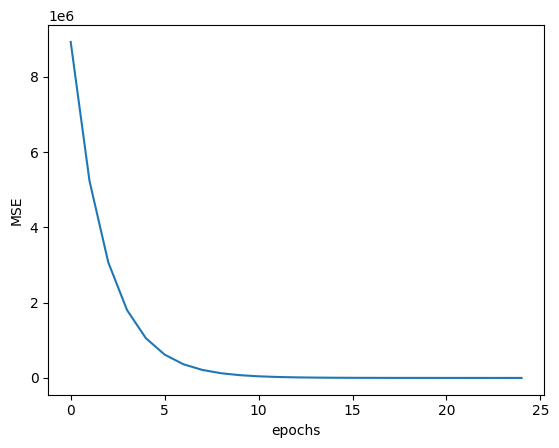

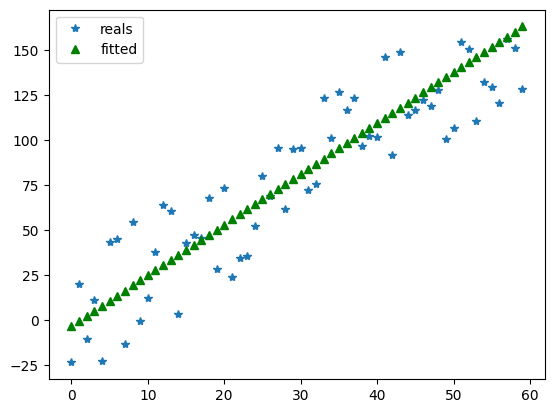

In [15]:
def compare_results(estim_w:float, estim_b:float, epochs:int, loss:list):
  """
  Plots loss per epoch and compares final function to real func
  """
  plt.figure()
  plt.plot(epochs, loss)
  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.figure()
  plt.plot(xs, ys, '*', label='reals')
  plt.plot(xs, linear_model(x=xs, w=estim_w, b=estim_b), 'g^', label='fitted')
  plt.legend()
  plt.show()

compare_results(estim_w=w_est, estim_b=b_est, epochs=epochs_list, loss=loss_per_epoch)

----------------
Nice! Let's extend this to fit a parabola,
$$y = ax^2 + bx + c$$

In [16]:
xs = np.arange(-30, 30)
noise = np.random.uniform(-80,80, size=(60,))

a = 3
b = 18
c = -5
ys = (a * xs**2) + (b * xs) + c + noise

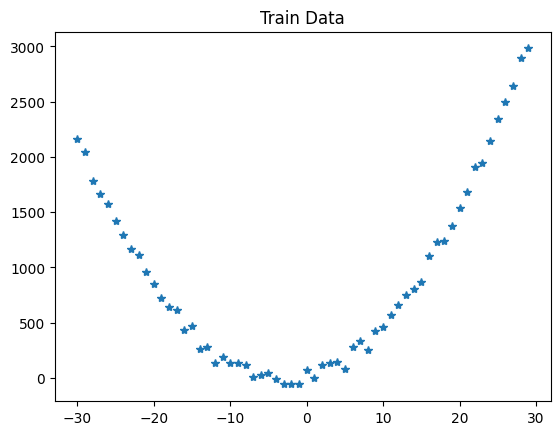

In [17]:
plt.figure()
plt.plot(xs, ys, '*')
plt.title('Train Data')
plt.show()

In [18]:
def quadratic_model(x:np.ndarray, a:float, b:float, c:float) -> np.ndarray:
    """
    Takes input data and scales/shifts by a,b,c parameters.
    """
    return a * x**2 + b * x + c

def dlda(x: np.ndarray, diff:np.ndarray, length:int)-> float:
  return -2 * diff.dot(x**2) / length

def dldb(x:np.ndarray, diff:np.ndarray, length:int)-> float:
  return -2 * diff.dot(x) / length

def dldc(diff:np.ndarray, length:int)-> float:
  return -2 * diff.sum() / length

def train_quad_loop(epochs: int,
                    a:float,
                    b:float,
                    c:float,
                    x:np.ndarray,
                    reals:np.ndarray,
                    lr:float = 0.001)-> tuple:
  """
  Control loop for training a quadratic model
  Args:
    epochs - number of update steps
    a - initial guess for paramter a
    b - initial guess for paramter b
    c - initial guess for paramter c
    x - input x axis data
    reals - true y values
    lr - learning rate
  Out:
    tuple of loss, epoch, a, b, c
  """

  epoch_count = [i for i in range(epochs)]
  loss_per_epoch = []
  N = len(x)

  for e in epoch_count:
    preds = quadratic_model(x=x, a=a, b=b, c=c)
    epoch_loss = loss(preds=preds, true=reals)
    loss_per_epoch.append(epoch_loss)

    diff = reals - preds
    a -= (lr * dlda(x=x, diff=diff, length=N))
    b -= (lr * dldb(x=x, diff=diff, length=N))
    c -= (lr * dldc(diff=diff, length=N))

  return loss_per_epoch, epoch_count, a, b, c

In [19]:
loss_vals, epochs, a, b, c = train_quad_loop(epochs = 800,
                a = 2,
                b = 1,
                c = 0.1,
                x = xs,
                reals = ys,
                lr = 0.000005)

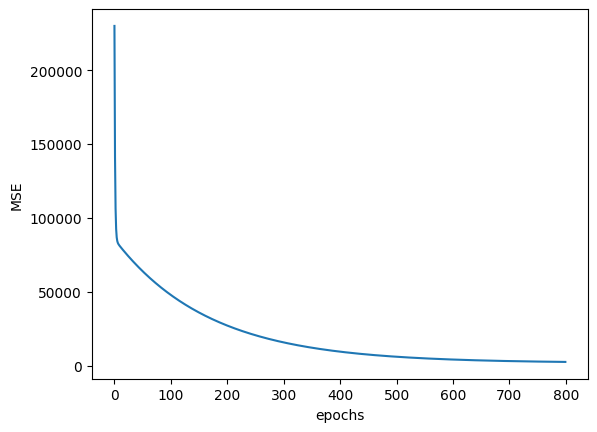

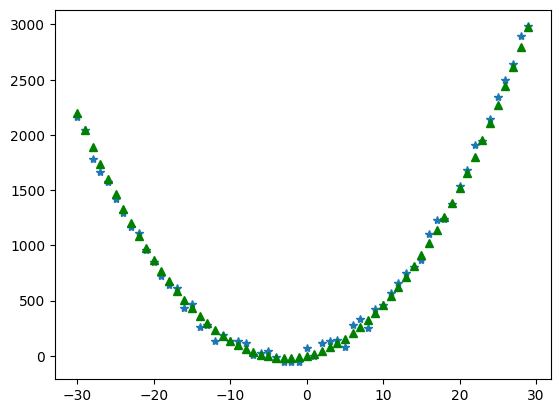

In [20]:
plt.figure()
plt.plot(epochs, loss_vals)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.figure()
plt.plot(xs, ys, '*')
plt.plot(xs, quadratic_model(x=xs, a=a, b=b, c=c), 'g^')
plt.show()